In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [10]:
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs

 89% 101M/113M [00:00<00:00, 137MB/s] 
100% 113M/113M [00:00<00:00, 132MB/s]


In [11]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cuhk-face-sketch-database-cufs.zip','r')
zip_ref.extractall('/content')

In [12]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re

In [4]:
def sorted_alphanumeric(path):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(path,key = alphanum_key)

In [13]:
SIZE = 256
image_path = '/content/photos'
img_array = []

sketch_path = '/content/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

In [14]:
len(image_file)

188

In [15]:
len(sketch_file)

188

In [16]:
image_file[0]

'f1-001-01.jpg'

(256, 256, 3)


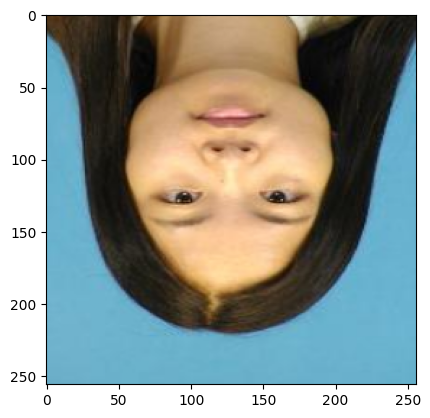

In [17]:
image = cv2.imread("/content/photos/f1-001-01.jpg")
# print(image.shape)
# plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (SIZE, SIZE))
print(image.shape)
image = image.astype('float32') / 255.0
img1 = cv2.flip(image,-1)
plt.imshow(img1)

In [18]:
for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0
    img_array.append(img_to_array(image))
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))

100%|██████████| 188/188 [00:01<00:00, 167.18it/s]


In [19]:
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|██████████| 188/188 [00:01<00:00, 173.96it/s]


In [20]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 1504
Total number of images: 1504


In [21]:
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)

    plt.show()

In [22]:
ls = [i for i in range(0,100,10)]
ls

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

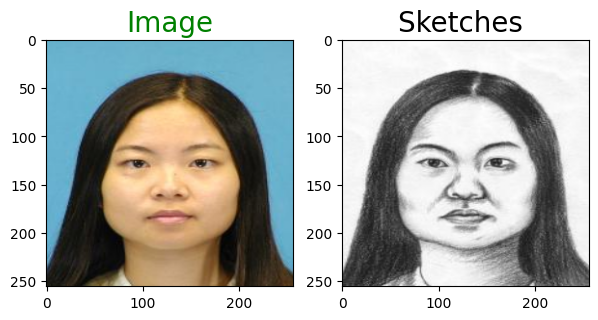

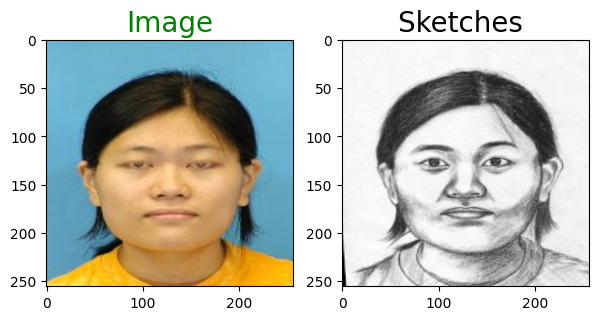

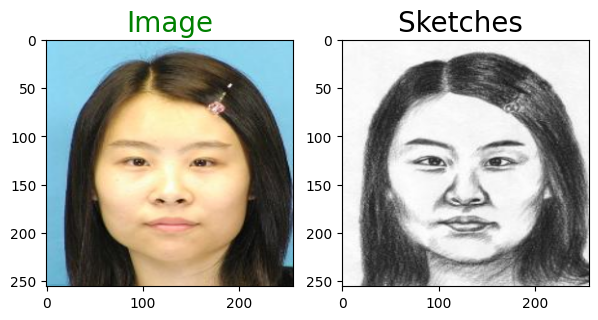

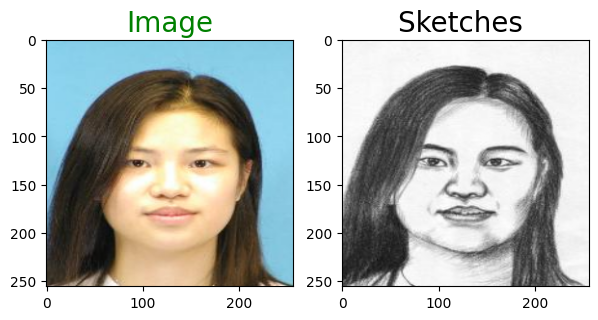

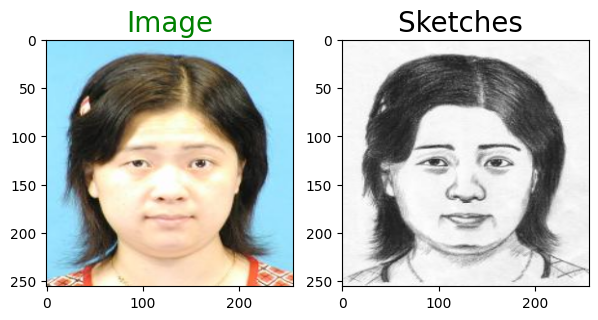

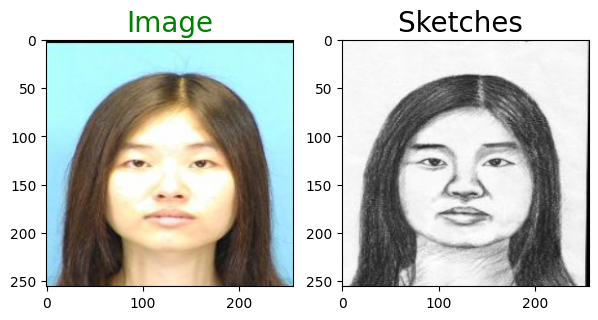

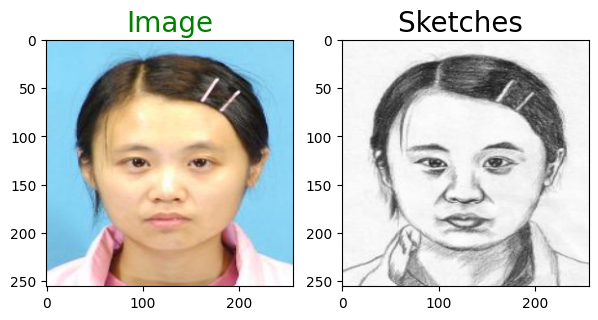

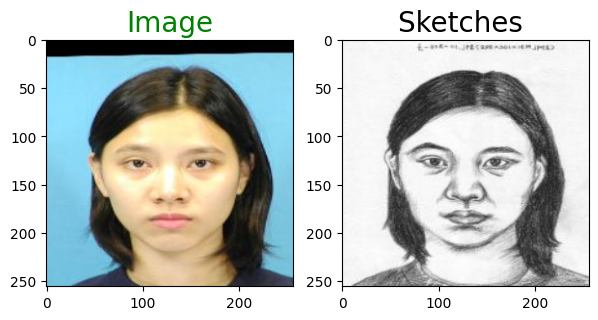

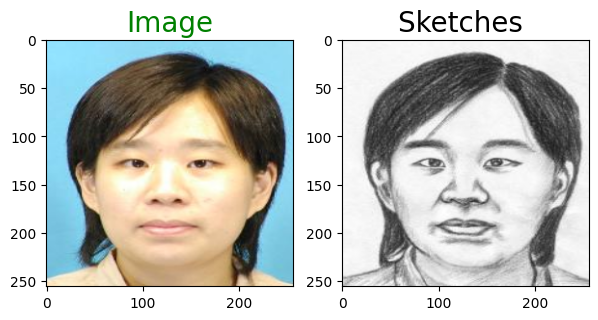

In [ ]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [23]:
train_image = img_array[:1400]
train_sketch_image = sketch_array[:1400]

test_image = img_array[1400:]
test_sketch_image = sketch_array[1400:]

In [24]:
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)

Train color image shape: (1400, 256, 256, 3)


In [25]:
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Test color image shape (104, 256, 256, 3)


In [26]:
def encoder(filters, size, apply_batch_normalization = True):
    encoder = tf.keras.models.Sequential()
    encoder.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        encoder.add(keras.layers.BatchNormalization())
    encoder.add(keras.layers.LeakyReLU())
    return encoder

In [27]:
def decoder(filters, size, apply_dropout = False):
    decoder = tf.keras.models.Sequential()
    decoder.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        decoder.add(tf.keras.layers.Dropout(0.1))
    decoder.add(tf.keras.layers.LeakyReLU())
    return decoder

In [28]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = encoder(16, 4, False)(encoder_input)
    x = encoder(32,4)(x)
    x = encoder(64,4,False)(x)
    x = encoder(128,4)(x)
    x = encoder(256,4)(x)

    encoder_output = encoder(512,4)(x)

    decoder_input = decoder(512,4,True)(encoder_output)

    x = decoder(256,4,False)(decoder_input)
    x = decoder(128,4, True)(x)
    x = decoder(64,4)(x)
    x = decoder(32,4)(x)
    x = decoder(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)


    return tf.keras.Model(encoder_input, decoder_output)

In [29]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      768       
                                                                 
 sequential_1 (Sequential)   (None, 62, 62, 32)        8320      
                                                                 
 sequential_2 (Sequential)   (None, 30, 30, 64)        32768     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       131584    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         525312    
                                                                 
 sequential_5 (Sequential)   (None, 2, 2, 512)         209920

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',metrics = ['acc'])

In [35]:
model.fit(train_image, train_sketch_image, epochs = 50, verbose = True)

Epoch 1/50
44/44 [==============================] - 7s 147ms/step - loss: 0.0991 - acc: 0.3228
Epoch 2/50
44/44 [==============================] - 7s 152ms/step - loss: 0.0944 - acc: 0.3220
Epoch 3/50
44/44 [==============================] - 7s 151ms/step - loss: 0.0923 - acc: 0.3260
Epoch 4/50
44/44 [==============================] - 7s 156ms/step - loss: 0.0918 - acc: 0.3262
Epoch 5/50
44/44 [==============================] - 7s 151ms/step - loss: 0.0939 - acc: 0.3279
Epoch 6/50
44/44 [==============================] - 7s 153ms/step - loss: 0.0896 - acc: 0.3263
Epoch 7/50
44/44 [==============================] - 7s 148ms/step - loss: 0.0870 - acc: 0.3278
Epoch 8/50
44/44 [==============================] - 7s 152ms/step - loss: 0.0861 - acc: 0.3263
Epoch 9/50
44/44 [==============================] - 6s 147ms/step - loss: 0.0845 - acc: 0.3248
Epoch 10/50
44/44 [==============================] - 7s 152ms/step - loss: 0.0829 - acc: 0.3247
Epoch 11/50
44/44 [==============================

In [36]:
prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

4/4 [==============================] - 0s 68ms/step - loss: 0.0798 - acc: 0.3406
Loss:  0.07977771759033203
Accuracy:  34.1


In [37]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

1/1 [==============================] - 0s 28ms/step


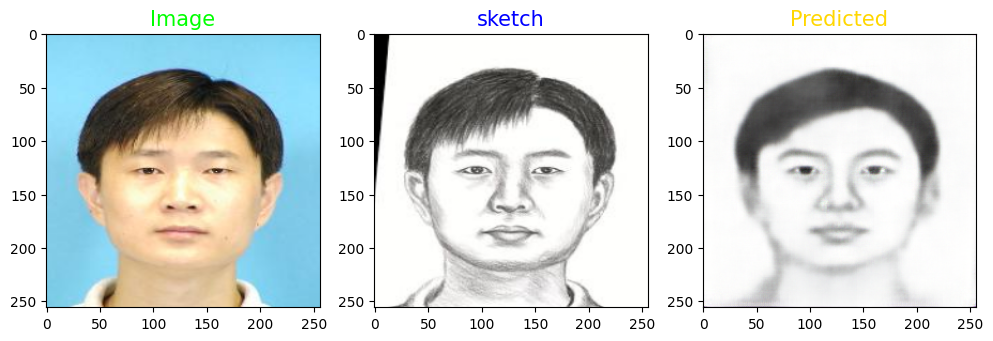

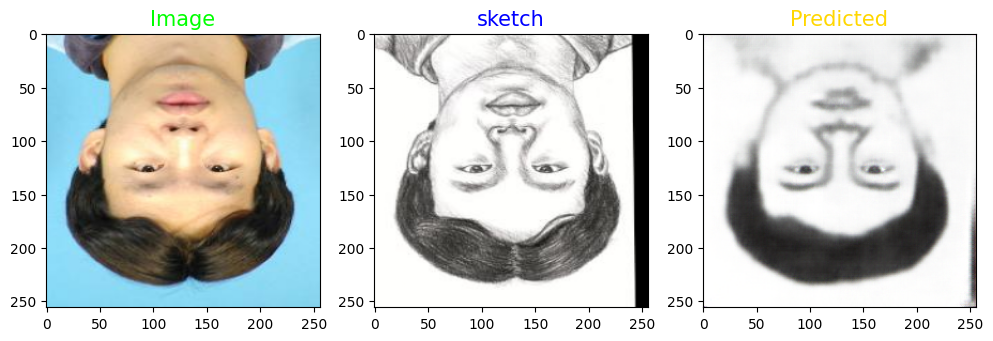

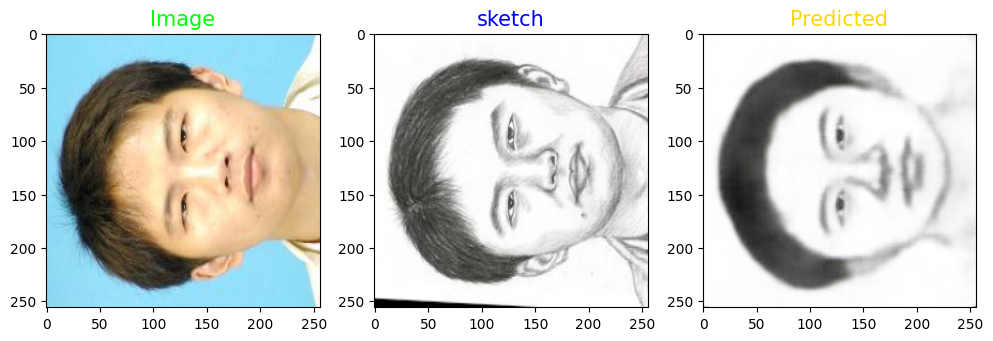

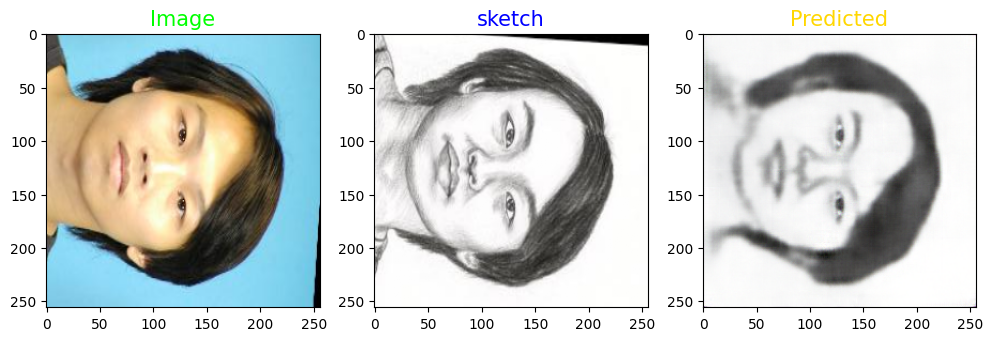

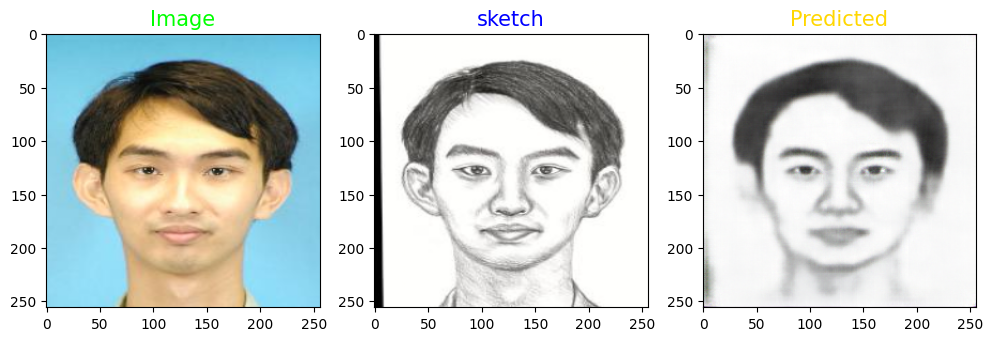

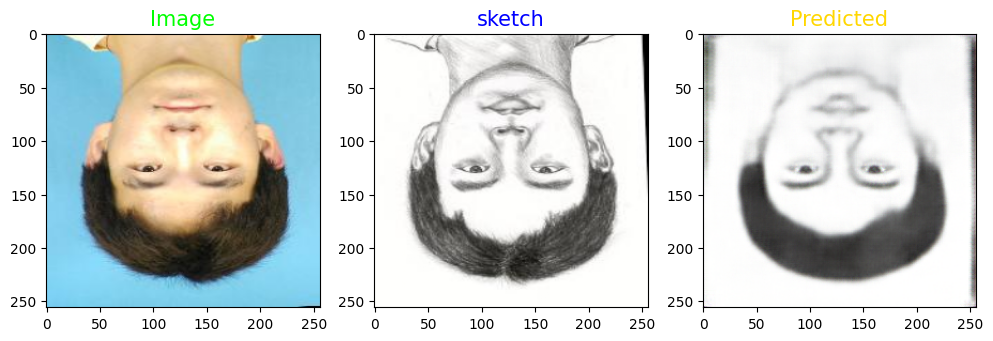

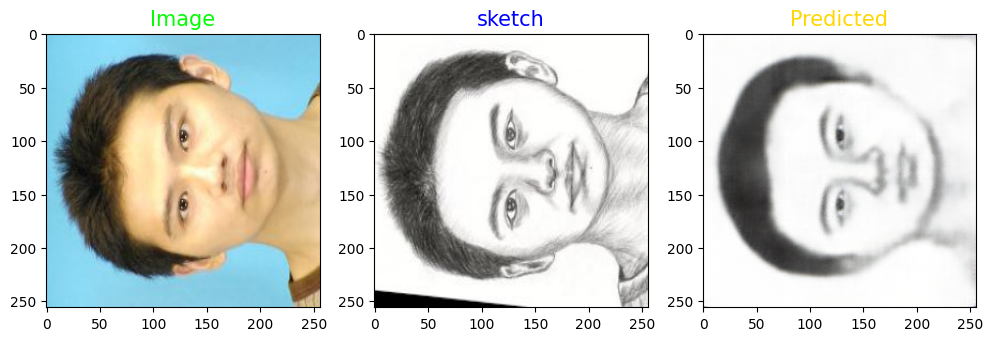

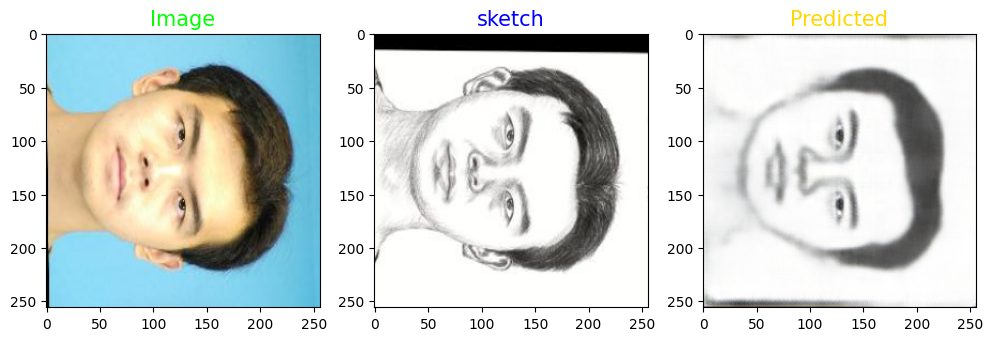

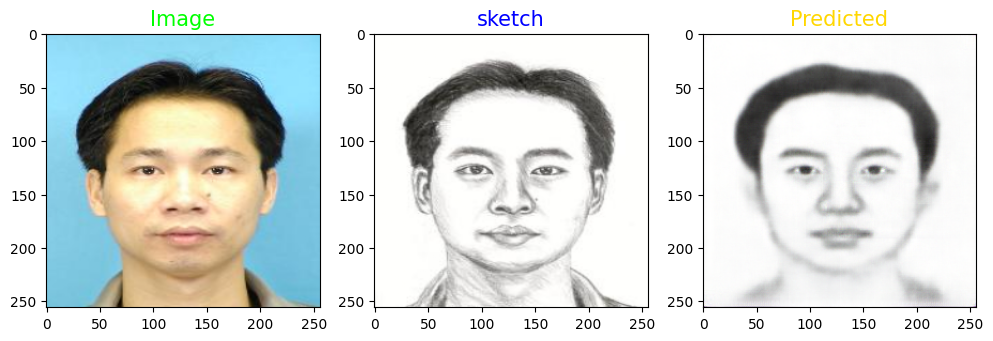

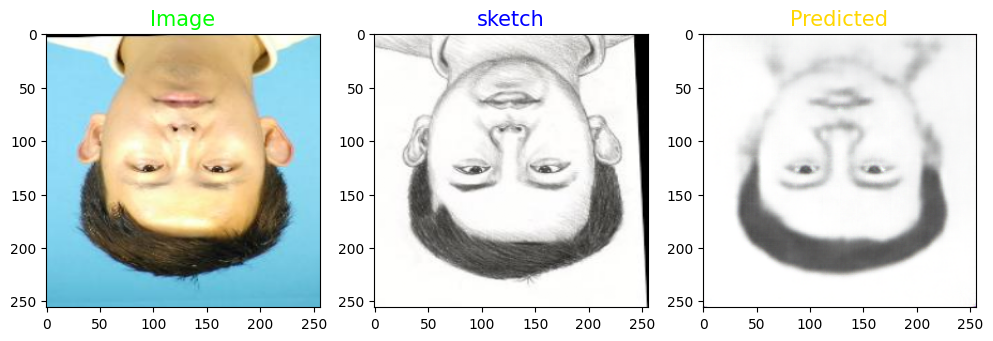

In [39]:
ls = [i for i in range(1,100,10)]
for i in ls:
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)